In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.utils import MixtureNormalSampler
import ott
import matplotlib.pyplot as plt
import numpy as np
import optax
import jax
import jax.numpy as jnp
import scanpy as sc

from entot.models.gen_model import OTFlowMatching, MLP_FM, MLP_FM2, MLP_FM3, MLP_FM_VAE, Bridge_MLP, MLP_no_noise

2023-07-19 11:31:23.426997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
adata = sc.read("../../../../data/adata_pancreas_2019_processed_new.h5ad")

In [5]:
sc.pp.pca(adata, n_comps=10)

In [6]:
source = adata[adata.obs["day"]=="14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["day"]=="15.5"].obsm["X_pca"].copy()


In [13]:
neural_net = MLP_no_noise(10, [128,128,128,128])
bridge_net = Bridge_MLP(10, 32, 32)
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()

In [14]:
otfm = OTFlowMatching(neural_net, bridge_net, ot_solver=ot_solver, epsilon=1e-3, input_dim=10, output_dim=10, iterations=3_000, noise_std=1e-1)

In [23]:
otfm.iterations=10_000
otfm(source, target, 512, 512)

100%|██████████| 10000/10000 [26:07<00:00,  6.38it/s]


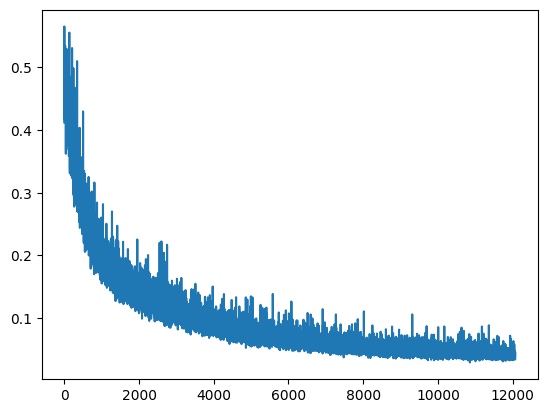

In [24]:
plt.plot(np.arange(len(otfm.metrics["loss"][500:])), otfm.metrics["loss"][500:])

In [25]:
pushed,_ = otfm.transport(source, seed=2)

In [26]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed[0,...], target), axis=0)

In [27]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

In [28]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


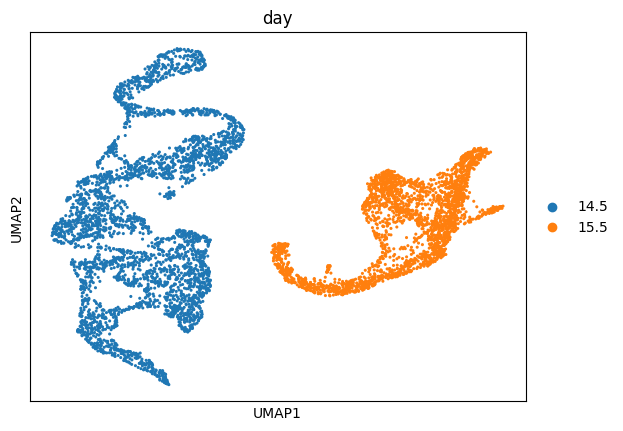

In [29]:
sc.pl.umap(bdata, color="day")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


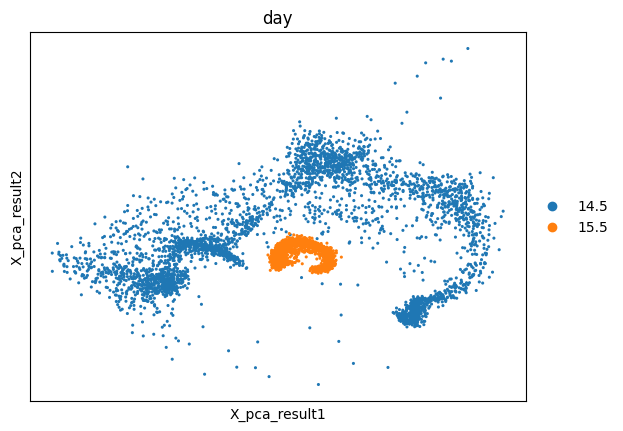

In [30]:
sc.pl.embedding(bdata, basis="X_pca_result", color="day")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


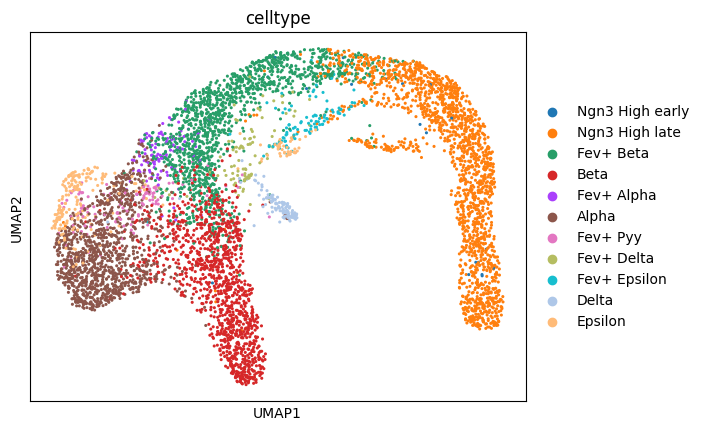

In [47]:
sc.pl.umap(bdata, color="celltype")

In [48]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source, seed=i)[0][0,...]


In [49]:
samples = jnp.array(res)

In [50]:
samples.shape

(15, 3575, 10)

In [51]:
vars = jnp.var(samples, axis=0)

In [52]:
vars_summed = jnp.sum(vars, axis=1)

In [53]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

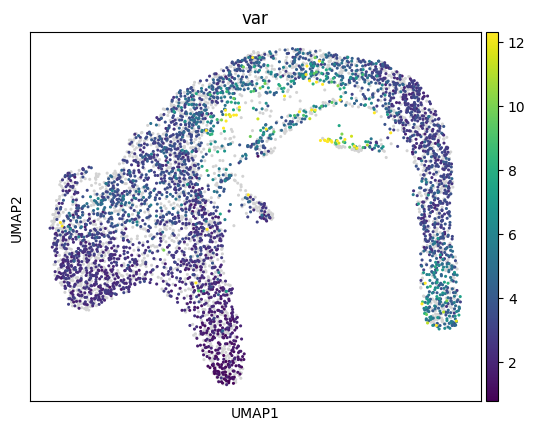

In [57]:
sc.pl.umap(bdata, color="var", vmax="p99")

In [55]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Ngn3 High early,8.139357
Ngn3 High late,4.129417
Fev+ Beta,4.103469
Beta,2.103152
Fev+ Alpha,3.249933
Alpha,2.750842
Fev+ Pyy,3.166773
Fev+ Delta,5.023872
Fev+ Epsilon,4.899799


In [ ]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  # type:ignore[override]
        transport_map: Callable[[jnp.ndarray], jnp.ndarray],
        src_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None), k=k)
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(src_cells), batch_size):
            _, indices = get_knn_fn(transport_map(src_cells[index : index + batch_size]), tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(src_cells) - index)), min(k, len(tgt_cells)))
            )
        row_indices = jnp.concatenate(row_indices)
        column_indices = jnp.concatenate(column_indices)
        tm = sp.csr_matrix((1.0, (row_indices, column_indices)), shape=[len(src_cells), len(tgt_cells)])
        return tm